# Week 10: Species Distribution Modelling

In this final exercise of the course we will be looking at species distribution modelling (SDM)! As
you have seen in the slides, there's generally two flavours of SDMs:
* _Mechanistic:_ here, the relationship rules between a habitat and its suitability for a species
  are manually/explicitly defined in a mathematical framework. For example: suitability for penguins
  = (annual temperature < 10 °C) * (latitude < -70 degrees). You can imagine that this becomes
  hard very quickly once we go beyond such dummy examples.
* _Correlative:_ hence, this form is more common. Here, we attempt to automatically identify
  patterns in the data and compare them to observed species occurrences; in other words, we cast it
  as a machine learning problem!


SDMs are the "bread and butter" in ecology and found everywhere – in fact, you have already used
some form of it in the last week (occupancy modelling).


Throughout the course _BIOS0032: AI for the Environment_, you have encountered and learnt to use
many models for a plethora of prediction tasks and datasets. Given that they are all one or another
flavour of machine learning model, they share the same basic principles that need to be heeded.
Recall figure from week 2:

![ml
workflow](https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/2_Intro_to_ML/ml_workflow.png?raw=true)

> Simplified workflow from: S. Amershi et al., ["Software Engineering for Machine Learning: A Case
> Study,"](https://ieeexplore.ieee.org/abstract/document/8804457) 2019 IEEE/ACM 41st International
> Conference on Software Engineering: Software Engineering in Practice (ICSE-SEIP), Montreal, QC,
> Canada, 2019, pp. 291-300, doi: 10.1109/ICSE-SEIP.2019.00042.


Hence, in this exercise we will address SDMs from a machine learning perspective here, going into
the details and pitfalls of training and using them. The main exercise uses random forests, but
there's also some deep learning at the end if you're interested!

# 0. Setup

## 0.1 Dependencies

In [ ]:
# installation of packages not present in Google Colab
%pip install rasterio

In [ ]:
from typing import Tuple, Dict
import os
import sys
import time
import hashlib
from google.colab import drive, output
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
import rasterio
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


RANDOM_SEED = 42

output.enable_custom_widget_manager()

## 0.2 Mount Google drive

Data used in this exercise is available in the public Google drive folder with this URL:
https://drive.google.com/drive/folders/1R81gwnmn5MiMuW2pQrkXFRVq9Yzlyg0g?usp=sharing

Follow these steps to use the dataset in this notebook:
1. Open the link and log in to your Google account (if needed).
2. Click the folder name in the heading, then "Organize" > "Add shortcut".
3. Select "My Drive", then click "Add".

In [ ]:
# mount Google drive
drive.mount('/content/drive')

# folder where we'll try to access files from
BASE_FOLDER = '/content/drive/MyDrive/UCL0032_AI4Environment/week_10/week10_exercise/data'

# we'll be using an external Python script down below
sys.path.append(os.path.join(BASE_FOLDER, 'misc'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data preparation

The dataset we'll be using in this exercise comes from the following paper:
> Winner, K., Ingenloff, K., Sandall, E., Sica, YV, Marsh, C., Cohen, J., Ranipeta, A., Killion, A.,
> Jetz, W.: _High Resolution Species Distribution Models of North American Biodiversity_. In
> preparation.

We'll be using a subset of three mammalian species occurrences over North America.


### 1.1 Observation data

Our observations come from GBIF
([10.15468/DL.ZP2JZF](https://www.gbif.org/occurrence/download/0291299-200613084148143)) and have
been pre-processed already, including removal of outliers and duplicates, and binning into 1km^2
resolution grid cells. Let us first load them from the CSV file into memory.

In [ ]:
# load data
observations = pd.read_csv(os.path.join(BASE_FOLDER,
                                        'observations/observations.csv'))

# keep tuple (= unmodifiable list) of species names
species_names = observations['species'].unique()
species_names = tuple(species_names)

print('First few rows of observations:')
print(observations.head())

First few rows of observations:
           id         lon        lat            species
0  1291145932 -111.679426  40.809944  Castor_canadensis
1  3301951503  -84.564820  46.542934  Castor_canadensis
2  2641537318  -89.252317  48.399635  Castor_canadensis
3  1890681417  -78.153489  44.198475  Castor_canadensis
4  3302091025 -116.975184  46.738737  Castor_canadensis


It's always a good idea to visualise your data. This facilitates finding potential outliers and
errors originating _e.g._ from any data pre-processing step. If your data includes
crowdsourcing-derived geospatial point records, these are often susceptible to inaccuracies due to
low-quality GPS recorders, or simply due to user error.

Let's plot these points on a map now. Just like for R, there's libraries available for Python that
can conveniently do this, such as GeoPandas (see [week 8](https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/8_AI_and_Movement_Data/)) and Plotly (which we'll use here).

In [ ]:
fig = px.scatter_mapbox(observations,
                        lat='lat',
                        lon='lon',
                        title='Observations',
                        hover_name='species',
                        color='species',
                        height=600,
                        width=800,
                        zoom=2)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

#### ❓

Read up on the three species regarding their habitat preferences and assumed distribution. A good
source is for example [Map of Life](https://mol.org/).

- Do these observations appropriately reflect these species' expected habitat range?

_➡️ Not really; observations are heavily biased by sampling effort (example: Castor canadensis occurs all the way through Canada/Alaska, yet there's hardly any points there)._
- Could you see any issues for modelling the three species together, for example in a joint SDM?

_➡️ A jSDM requires sufficient overlap in habitats between species, which is not really given here._

### 1.2 Pseudo-absences

As is often the case, we only have (opportunistically sampled) observations, but no confirmed
absences of species (which are much harder to obtain). This causes problems for _both_ training and
testing habitat suitability models.

A standard approach in this case is to sample additional locations in a random or semi-random
manner, and designate these as _pseudo-absences_. This may seem counterintuitive to do so, but our
chances of accidentally including suitable locations as pseudo-absences is surprisingly low. Yet,
the quality of these pseudo-absences still depends on the way they are sampled.

For this exercise, you are given three sets of differently sampled pseudo-absences
(`absences_a.csv`, `absences_b.csv`, `absences_c.csv`), which get loaded and visualised in the code
below.


#### ❓
- Can you identify the differences between those three sets? Tip: it might help to display
  observations _vs._ pseudo-absences for one species at a time; feel free to modify the code to this
  end.

_➡️ `observations_a`: pseudo-absences are sampled within the same area as occurrences. `observations_b`: pseudo-absences are sampled randomly across study area. `observations_c`: they are sampled outside the area the particular species has been observed._

- Imagine you had to write your own code to sample pseudo-absences. What do you need to do to get
  meaningful ones? List the main steps you deem necessary (no need for code or pseudocode).

_➡️ 1. consolidate all occurrence records; 2. obtain land mask (land areas without oceans or lakes); 3. create buffer around occurrence records to avoid pseudo-absences being too close; 4. (optional) create negative buffer for land mask to avoid samples in the ocean; 5. sample points according to set heuristic (random, within, or outside species domain), repeat if no. samples is insufficient._

In [ ]:
# read CSV file of predefined pseudo-absences
pseudo_absences = pd.read_csv(os.path.join(BASE_FOLDER,
                                           'observations',
                                           'pseudo_absences_c.csv'))

# add extra column to differentiate between observations (presence points)
# and pseudo-absences
pseudo_absences['is_presence'] = False

# merge observations & pseudo-absences data frames into a new one
observations['is_presence'] = True
data = observations.copy()._append(pseudo_absences)

# plot
fig = px.scatter_mapbox(data,
                        lat='lat',
                        lon='lon',
                        title='Observations & pseudo-absences',
                        hover_name='species',
                        color='is_presence',
                        height=600,
                        width=800,
                        zoom=2)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

### 1.3 Covariates

We'll be using the following thematic layers as covariates for this exercise:
* `meanAnnualTemp`: mean annual air temperature [CHELSA]
* `seasonalityPrecip`: precipitation seasonality [CHELSA]
* `accumPrecip`: accumulated precipitation on growing season days [CHELSA]
* `cloudCoverAnnualVar`: cloud cover intra-annual variation [EarthEnv]
* `topoRugged`: topographic ruggedness index [EarthEnv]
* `varEVI`: spatial variation of the enhanced vegetation index (EVI) [EarthEnv]
* `summerEVI`: mean summer EVI (Jun-Aug) [MODIS]
* `winterEVI`: mean winter EVI (Nov-Feb) [MODIS]

Sources:
* [CHELSA] https://chelsa-climate.org/
* [EarthEnv] https://www.earthenv.org/
* [MODIS] https://lpdaac.usgs.gov/products/mod13q1v006/

In [ ]:
# let us first define a tuple (= fixed list) of the covariates, in order
covariate_ids = (
    'meanAnnualTemp',
    'seasonalityPrecip',
    'accumPrecip',
    'cloudCoverAnnualVar',
    'topoRugged',
    'varEVI',
    'summerEVI',
    'winterEVI'
)

In [week 9](https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/9_AItoEcologicalModels) we've seen how to sample covariate values at given geospatial locations using R. Naturally, we can do the same in Python, for example using the Rasterio library.

#### ❓
- Consult the Rasterio documentation on how to sample values from a geospatial image. Use this
  knowledge to complete the code below.

In [ ]:
def sample_covariates(locations: pd.DataFrame,
                      geotiff_path: str) -> Tuple[float]:
    '''
        Receives geospatial coordinates (lat, lon) and a path to a GeoTIFF file and samples values
        from the GeoTIFF.

        Inputs:
        - "locations": Pandas.DataFrame, containing (at least) "lat" and "lon" columns with
          coordinates.
        - "geotiff_path": str, path to GeoTIFF file that needs to be sampled.

        Returns:
        - tuple of floats, containing per-point sampled values in order of "locations"
    '''
    # prepare locations by converting lat+lon columns into list of (lat, lon) tuples
    # tip: read up on Python's "zip" command
    coordinates = zip(locations['lon'], locations['lat'])

    # load GeoTIFF in rasterio
    with rasterio.open(geotiff_path, 'r') as f_raster:
      values = np.array(tuple(f_raster.sample(coordinates))).squeeze()

      # mask no data values if present
      if f_raster.nodata is not None:
        invalid = values == f_raster.nodata
        values = values.astype(float)
        values[invalid] = float('nan')
    return values


# sample covariate values by iterating over GeoTIFFs in our specified order
for cov_id in tqdm(covariate_ids):
  # GeoTIFF file path
  geotiff_path = os.path.join(BASE_FOLDER, 'rasters', f'{cov_id}.tiff')

  # sample values on locations defined in "obs_merged" and append to covariates DataFrame
  sampled_values = sample_covariates(data, geotiff_path)
  data[cov_id] = sampled_values


# remove rows with NaN values
print(f'# samples: {len(data)}.')
data.dropna(axis=0,
            inplace=True)
print(f'# samples after dropping NaN values: {len(data)}.\n')


# display the first few rows (this now contains both observations+pseudo-absences *and* covariates)
print(data.head())

100%|██████████| 8/8 [00:52<00:00,  6.57s/it]

# samples: 5086.
# samples after dropping NaN values: 4099.

           id         lon        lat            species  is_presence  \
0  1291145932 -111.679426  40.809944  Castor_canadensis         True   
1  3301951503  -84.564820  46.542934  Castor_canadensis         True   
2  2641537318  -89.252317  48.399635  Castor_canadensis         True   
4  3302091025 -116.975184  46.738737  Castor_canadensis         True   
5   899959583  -96.887667  29.903000  Castor_canadensis         True   

   meanAnnualTemp  seasonalityPrecip  accumPrecip  cloudCoverAnnualVar  \
0          2796.0              253.0       2970.0          1289.967041   
1          2779.0              239.0       5689.0          1430.652222   
2          2766.0              338.0       4241.0           975.012024   
4          2824.0              366.0       3100.0          2003.784180   
5          2938.0              233.0       9934.0           441.327332   

   topoRugged       varEVI    summerEVI    winterEVI  
0   32

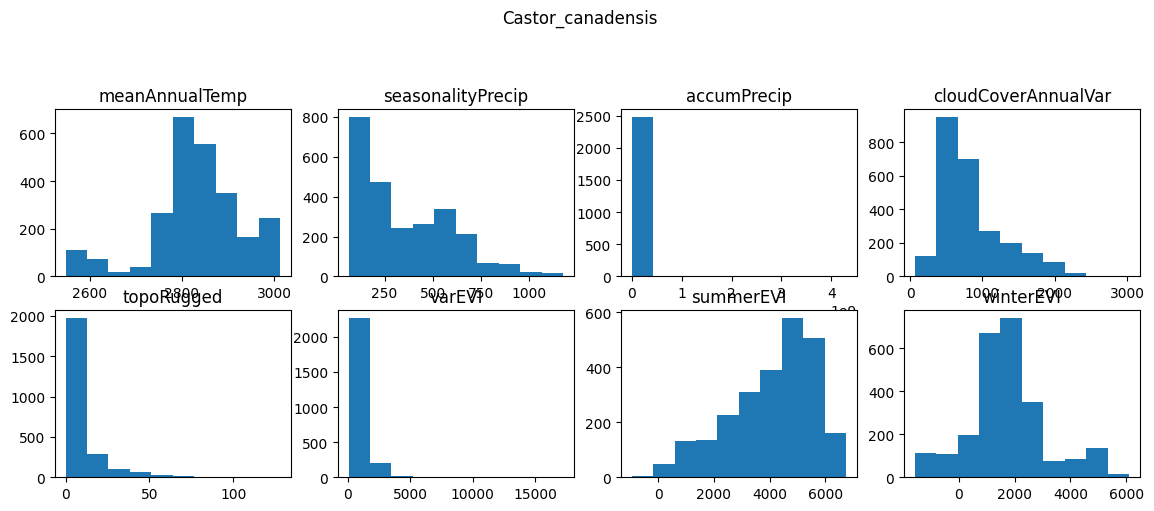

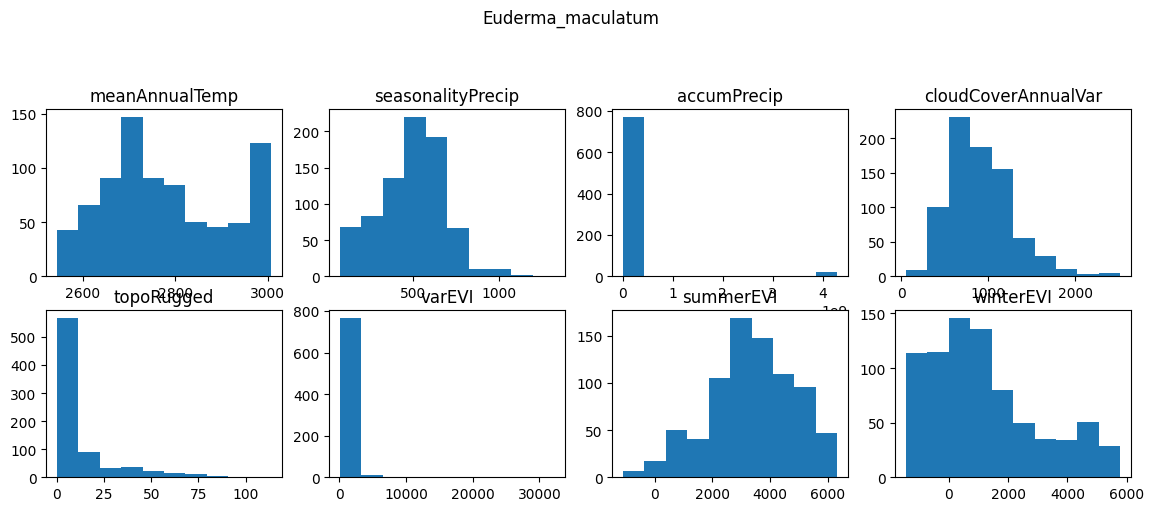

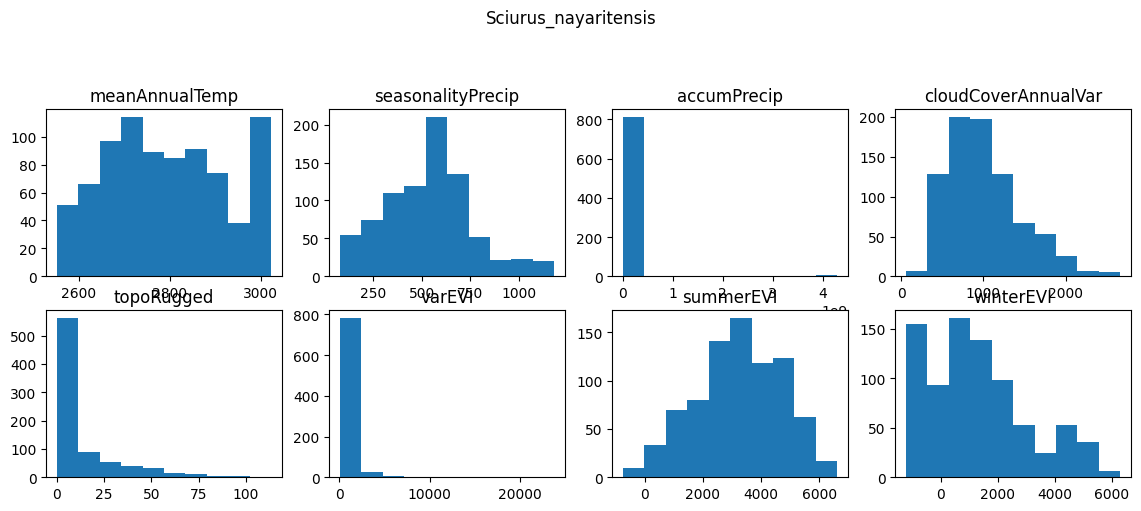

In [ ]:
# plot covariate histograms for each species
for species_name in species_names:
    valid_rows = data['species'] == species_name

    plt.figure(figsize=(14,10))
    for cidx, covariate_id in enumerate(covariate_ids):
        plt.subplot(4,4,cidx+1)
        plt.hist(data.loc[valid_rows,covariate_id])
        plt.title(covariate_id)
    plt.suptitle(species_name)
    plt.show()

## 2. Data splitting

Since our species distribution modelling procedure is based on correlative measurements obtained
from known data points, it is a machine learning (ML) problem. As such, it has to follow all the
typical ML requirements and prerequisites, one of which is a means to test for generalisation
inability, or overfitting (see [week
2](https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/2_Intro_to_ML)).
To test for this, we basically need three datasetes (recap):
* a _training_ dataset to fit the model to (tune model parameters);
* a _validation_ dataset to tune the model's **hyper**parameters for maximum generalisation out of
  the known set of samples (training set);
* at the very end, a _test_ set to get a final performance score on data the model truly has never
  seen.

The idea then is to iteratively train-test the model on the training and validation sets, and tune
its parameters and hyperparameters before eventually applying it on the test set.

In ecology, one often sees multiple runs of training-validation on different partitionings (folds),
known as k-fold crossvalidation. This is a good idea to increase the confidence in generalisation
ability, but it should not replace a dedicated test set (in theory...).

Naturally, all three datasets should follow the same underlying distribution. This is where species
distribution modelling becomes difficult: not only do the _covariates_ be equally sampled, but also
the _labels_ (observations).

In the following, we will split the data into three sets (training, validation, test) based on
pre-defined percentages (stratified by species), and sampled randomly.

#### ❓
- Is this an adequate way of splitting the data? Why so, resp. why not?

_➡️ No: random splitting likely induces information leakage across splits due to spatial autocorrelation._

- We use single-species distribution models below. Do you see additional problems if we were to use
  a multi- or joint SDM instead?

_➡️ Yes, because stratification of splitting by species means that points nearby of different species might end up in different splits (again, information leakage)._

- Likewise, what would be the problem with this idea if we used spatial context for covariates
  instead of single point values?

_➡️ With spatial patches, nearby points will definitely be shared across splits, even if partially._

In [ ]:
def split_random(data: pd.DataFrame,
                 percentage_train: float=60.0,
                 percentage_test: float=30.0) -> Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    '''
        Receives an observations table and percentage values for the training and test set
        (remainder is used for validation set). Splits the observations into train, val, and test
        sets at random.

        Inputs:

        - "observations": Pandas.DataFrame, containing locations and column "species" with observed
          labels
        - "percentage_train": float, percent of observation rows assigned randomly to training set
        - "percentage_test": float, the same for the validation set

        Returns:

        - three Pandas.DataFrame instances containing train, val, test subsets of input
          "observations" Pandas.DataFrame.
    '''
    percentage_val = max(0.0, 100 - percentage_train - percentage_test)

    train, val, test = [], [], []

    # split observations and pseudo-absences separately
    for abs_val in (False, True):
      subset = data[data['is_presence'] == abs_val]

      # split at random
      train_sub, test_sub = train_test_split(subset,
                                             test_size=(percentage_test+percentage_val)/100.0,
                                             train_size=percentage_train/100.0,
                                             shuffle=True,
                                             random_state=RANDOM_SEED,
                                             stratify=subset['species'])

      # split test set again for validation set
      val_sub, test_sub = train_test_split(test_sub,
                                  test_size=percentage_test/(percentage_test+percentage_val),
                                  train_size=percentage_val/(percentage_test+percentage_val),
                                  shuffle=True,
                                  random_state=RANDOM_SEED,
                                  stratify=test_sub['species'])

      # append
      train.append(train_sub)
      val.append(val_sub)
      test.append(test_sub)

    # concatenate observation and pseudo-absence subsets into data frames
    train = pd.concat(train, axis=0)
    val = pd.concat(val, axis=0)
    test = pd.concat(test, axis=0)

    return train, val, test


# do the splitting
data_train, data_val, data_test = split_random(data,
                                               60.0,
                                               30.0)


# visualise
data_train['split'] = 'train'
data_val['split'] = 'val'
data_test['split'] = 'test'
data = pd.concat((data_train, data_val, data_test),
                 axis=0)
fig = px.scatter_mapbox(data,
                        lat='lat',
                        lon='lon',
                        hover_name='split',
                        color='split',
                        height=600,
                        width=800,
                        zoom=2)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

## 3. Hyperparameter tuning

We can now think about training our SDMs, including tuning their hyperparameters. This includes the
following steps:

For each hyperparameter combination:
1. Train model with parameters on training set.
2. Obtain predictions by applying trained models to validation set.
3. Evaluate model performance on validation set.
Then, pick the hyperparameter combination of choice.


With that in mind, let us first implement three generic functions for (i.) model training, (ii.)
prediction, and (iii.) performance evaluation. We shall use random forests as SDMs for this
exercise. You have seen those before in [week
2](https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/tree/main/2_Intro_to_ML).


#### ❓
- Complete the gaps in the code below.
- For performance evaluation, you will have to choose a metric. There are many options, not all of
  which are adequate here. Tip: read through and choose from what
  [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html) has to offer.

_➡️ The most common metric for presence-only SDMs is to use $AUC_{ROC}$. Other measures like e.g. Boyce index also exist, but should be used in addition to that one._

In [ ]:
def train(data: pd.DataFrame,
          hyperparameters: dict=None) -> Dict[str, RandomForestClassifier]:
    '''
        Main training function for random forest.
    '''
    if hyperparameters is None:
        hyperparameters = {}

    models = {}     # dict of species: model instances

    # iterate over all species
    for species in species_names:
        # subset data for species
        valid = data['species'] == species

        # train model
        model = RandomForestClassifier(**hyperparameters)
        model.fit(X=data.loc[valid,covariate_ids],
                  y=data.loc[valid,'is_presence'])

        # add to dict
        models[species] = model

    return models



def predict(data: pd.DataFrame,
            models: Dict[str, RandomForestClassifier]) -> pd.DataFrame:
    '''
        Main prediction function for random forest.
    '''
    # initialise empty dict of predictions
    predictions = {}

    # iterate over all species
    for species in species_names:
        model = models[species]

        # get predicted probabilities
        pred = model.predict_proba(data.loc[:,covariate_ids])

        # we have two classes (is_presence = False or True), so let's extract the "True" column vals
        col = np.where(model.classes_ == True)[0]
        pred = pred[:,col].squeeze()
        predictions[species] = pred

    # convert to DataFrame
    predictions = pd.DataFrame(predictions)
    predictions.index = data.index
    return predictions



def evaluate(predictions: pd.DataFrame,
             labels: pd.DataFrame) -> Dict[str,float]:
    '''
        Main evaluation function for any form of predictions with pseudo-probabilities.
    '''
    # initialise empty dict of performance scores
    scores = {}

    # iterate over all species
    for species in species_names:
        # subset labels accordingly
        valid = np.where(labels['species']==species)[0]

        labels_sub = labels['is_presence'].iloc[valid]
        pred_sub = predictions[species].iloc[valid]

        # calculate metric
        auc_roc = metrics.roc_auc_score(y_true=labels_sub,
                                        y_score=pred_sub)
        scores[species] = auc_roc

    return scores

We now have all the ingredients to tune our random forest's hyperparameters.

#### ❓
Read up on the random forest as provided in the `Scikit-learn` library.

- Which hyperparameters does it offer, and which of those make sense to be tuned?

_➡️ Most common hyperparameters to tune in a random forest are the number of estimators (trees) and maximum tree size (controllable by e.g. minimum leaf size or maximum tree depth)._

- Pick your two favourites and perform a grid search on the best combination of them. Do so by
  completing the code below.

Starting crossvalidation...


[n_estimators: 1000; max_depth: 100] score: 0.97, time: 8.36 s: 100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


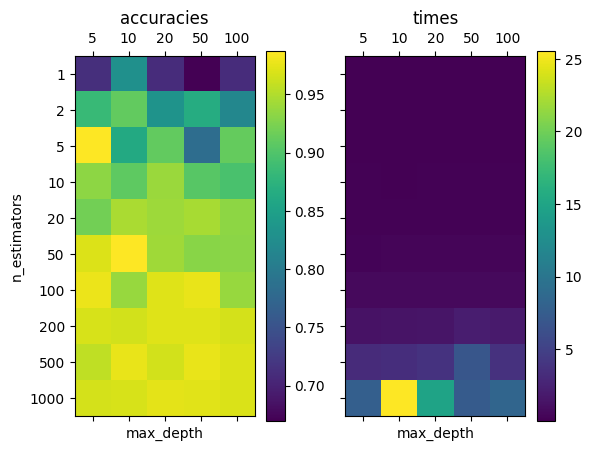

In [ ]:
# example hyperparameters in solution: `n_estimators`, `max_depth`
HYPERPARAMETERS = {
    'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'max_depth': [5, 10, 20, 50, 100]
}

# prepare matrix of all combinations of both hyperparameters (cartesian product)
param_a, param_b = tuple(HYPERPARAMETERS.keys())
vals_a, vals_b = np.meshgrid(HYPERPARAMETERS[param_b], HYPERPARAMETERS[param_a])

# prepare matrix of crossvalidation results: here, we measure both accuracy and training time
accuracies, times = np.zeros_like(vals_a, dtype=float), np.zeros_like(vals_a, dtype=float)

# iterate over all possible combinations of both hyperparameters
print('Starting crossvalidation...')
with tqdm(range(len(HYPERPARAMETERS[param_a])*len(HYPERPARAMETERS[param_b]))) as pbar:
    for idx_a, val_a in enumerate(HYPERPARAMETERS[param_a]):
        for idx_b, val_b in enumerate(HYPERPARAMETERS[param_b]):
            hyperparameters = {
                param_a: val_a,
                param_b: val_b
            }

            # 0. start time
            tic = time.time()

            # 1. train Random Forests on training set using current set of hyperparameters
            models = train(data_train, hyperparameters)

            # 2. use trained models to predict validation set
            predictions = predict(data_val, models)

            # 3. evaluate predictions using accuracy measure
            scores = evaluate(predictions, data_val)
            score_avg = np.mean(list(scores.values()))          # average across all species

            # 4. stop time
            toc = time.time()
            duration = toc - tic

            # store values
            accuracies[idx_a,idx_b] = score_avg
            times[idx_a,idx_b] = duration

            pbar.set_description(f'[{param_a}: {val_a}; {param_b}: {val_b}] ' + \
                    f'score: {score_avg:.2f}, time: {duration:.2f} s')
            pbar.update(1)


# plot result as matrices
ticks_x, ticks_y = range(len(HYPERPARAMETERS[param_b])), range(len(HYPERPARAMETERS[param_a]))

_, axes = plt.subplots(1,2, sharey=True)
plot_a = axes[0].matshow(accuracies.astype(float))
axes[0].set_xticks(ticks_x, HYPERPARAMETERS[param_b])
axes[0].set_yticks(ticks_y, HYPERPARAMETERS[param_a])
axes[0].set_ylabel(param_a)
axes[0].set_xlabel(param_b)
axes[0].set_title('accuracies')
plt.colorbar(plot_a)
plot_b = axes[1].matshow(times.astype(float))
axes[1].set_xticks(ticks_x, HYPERPARAMETERS[param_b])
axes[1].set_yticks(ticks_y, HYPERPARAMETERS[param_a])
axes[1].set_xlabel(param_b)
axes[1].set_title('times')
plt.colorbar(plot_b)
plt.show()

In [ ]:
# select your favourite set of hyperparameters here
HYPERPARAMETERS = {
    'n_estimators': 50,
    'max_depth': 10
}

# 4. Train, predict, and evaluate

## 4.1 Check performance across splits

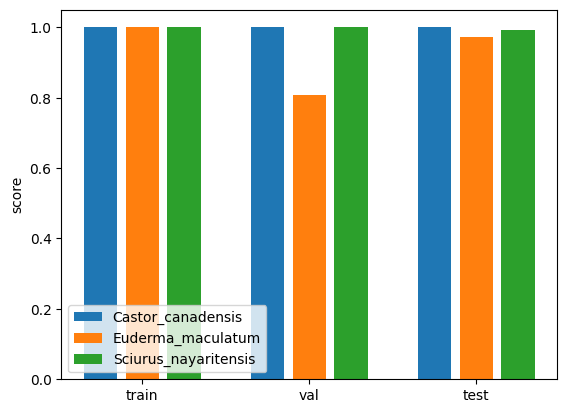

In [ ]:
# 1. train Random Forests on training set using your final set of hyperparameters
models = train(data_train, HYPERPARAMETERS)

# 2. use trained models to predict all three sets
pred_train = predict(data_train, models)
pred_val = predict(data_val, models)
pred_test = predict(data_test, models)

# 3. evaluate predictions using accuracy measure
scores_train = evaluate(pred_train, data_train)
scores_val = evaluate(pred_val, data_val)
scores_test = evaluate(pred_test, data_test)

# combine
scores = pd.DataFrame({'train': scores_train,
                       'val': scores_val,
                       'test': scores_test})

# plot
plt.figure()
for sidx, species in enumerate(species_names):
    plt.bar(range(sidx, len(species_names)*4, 4), scores.loc[species], label=species)
plt.ylabel('score')
plt.xticks(range(1, len(species_names)*4, 4), ('train', 'val', 'test'))
plt.legend(loc='lower left')
plt.show()

## 4.2 Predict map

In [ ]:
# 1. Define locations on uniform grid across study area
landmask = gpd.read_file(os.path.join(BASE_FOLDER,
                                      'misc',
                                      'NA_land_area.geojson'))

# unionise polygons from different continents
landmask = gpd.GeoDataFrame(index=[0],
                            crs=landmask.crs,
                            geometry=[landmask.unary_union])
bounds = landmask.bounds

# we sample with limited resolution here
RESOLUTION = 0.5            # degrees (1 degree ~= 111km)
loc_lon = np.arange(bounds.minx[0], bounds.maxx[0], RESOLUTION)
loc_lat = np.arange(bounds.miny[0], bounds.maxy[0], RESOLUTION)
grid_lon, grid_lat = np.meshgrid(loc_lon, loc_lat)

# remove points not on land
points = [Point(row) for row in list(zip(grid_lon.ravel(), grid_lat.ravel()))]
data_map = gpd.GeoDataFrame(data={'lon': grid_lon.ravel(), 'lat': grid_lat.ravel()},
                            geometry=points,
                            crs=landmask.crs)

In [ ]:
# 2. Sample covariates
for cov_id in tqdm(covariate_ids):
  # GeoTIFF file path
  geotiff_path = os.path.join(BASE_FOLDER, 'rasters', f'{cov_id}.tiff')

  # sample values on locations defined in "obs_merged" and append to covariates DataFrame
  sampled_values = sample_covariates(data_map, geotiff_path)
  data_map[cov_id] = sampled_values

# drop NaNs
data_map.dropna(inplace=True)

100%|██████████| 8/8 [00:22<00:00,  2.83s/it]


In [ ]:
# 3. Predict using trained Random Forests
pred_map = predict(data_map, models)

In [ ]:
# 4. Plot
df_map = pd.concat((pred_map, data_map), axis=1)


def plot_predictions(species: str,
                     plot_observations: bool=False) -> None:
    traces = []
    fig_pred = px.scatter_mapbox(df_map,
                                 lat='lat',
                                 lon='lon',
                                 title='Predictions',
                                 hover_name=species,
                                 color=species,
                                 height=600,
                                 width=800,
                                 zoom=2)
    traces.append(fig_pred.data[0])
    if plot_observations:
        fig2 = px.scatter_mapbox(data.loc[(data['species']==species) * \
                                          (data['is_presence']==True)],
                                 lat='lat',
                                 lon='lon',
                                 title='Observations',
                                 hover_name='species',
                                 color_discrete_sequence=['green'],
                                 height=600,
                                 width=800,
                                 zoom=2)
        traces.append(fig2.data[0])
    fig = go.FigureWidget(data=traces)
    fig.update_layout(mapbox_style='open-street-map')
    fig.show()


species_wdgt = widgets.Dropdown(options=species_names, description='species:')
show_obs_wdgt = widgets.Checkbox(description='show observations')

def redraw_figure(*args, **kwargs):
    clear_output(wait=True)
    display(species_wdgt, show_obs_wdgt, fig)
    plot_predictions(species=species_wdgt.value,
                     plot_observations=show_obs_wdgt.value)

species_wdgt.observe(redraw_figure, names=['value'])
show_obs_wdgt.observe(redraw_figure, names=['value'])


redraw_figure()

Dropdown(description='species:', options=('Castor_canadensis', 'Euderma_maculatum', 'Sciurus_nayaritensis'), v…

Checkbox(value=False, description='show observations')

FigureWidget({
    'data': [{'hovertemplate': ('<b>%{hovertext}</b><br><br>lat' ... '%{marker.color}<extra></extra>'),
              'hovertext': array([0.87602365, 0.83594894, 0.78930217, ..., 0.92891884, 0.92891788,
                                  0.88670361]),
              'lat': array([-1.7870363, -1.7870363, -1.7870363, ..., 77.7129637, 77.7129637,
                            77.7129637]),
              'legendgroup': '',
              'lon': array([-80.4734456, -79.9734456, -79.4734456, ..., -69.9734456, -68.9734456,
                            -68.4734456]),
              'marker': {'color': array([0.87602365, 0.83594894, 0.7893022 , ..., 0.92891884, 0.9289179 ,
                                         0.8867036 ], dtype=float32),
                         'coloraxis': 'coloraxis'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox',
              'uid': '22b0e36

#### ❓

* Are you satisfied with the results, and does the visual quality of the map correspond to the accuracy values you obtained?

_➡️ The random forests are generally able to highlight areas of high observation density. Low-density areas (e.g., Alaska, northern Canada for Castor canadensis) are not predicted properly. Results are also somewhat worse for species with low observation count._

* Repeat model training and testing with a different set of pseudo-absences (`pseudo_absences_b.csv` and `pseudo_absences_c.csv` under Section 1.2). How do model accuracy and map predictions change?

_➡️ `observations_b.csv` (uniform random): sampling bias gets amplified (even more focused on high observation count areas); model becomes overconfident in range area size. `observations_c.csv` (sampled outside species domain): accuracy metrics are inflated; maps closely cling to observations in space._

* Why do you think that is the case?

_➡️ In both cases, the problem becomes "too easy", as the contrast between observations and pseudo-absences is large enough for a model to make a simple decision. `observations_b.csv`: separation between observations and pseudo-absences becomes unclear, as both "easy" pseudo-absences (with covariates far away from observations) and harder ones (nearby) are mixed together. For some species it also results in random areas being "lit up"; this "jagginess" is also due to the increased confusion between points. `observations_c.csv`: explicitly excluding regions of observations when sampling pseudo-absences reduces confusion for the model and generally improves visual patterns._

# 5. Bonus: Deep Learning model

Remember week 3 where we used deep learning models to classify camera trap images? Let's use them as
SDMs here!

In the exercise of week 3, you have seen the most important steps (model creation, data
augmentation, _etc._). We can do pretty much the same here (augmentation is harder with non-image
data, so we'll leave it for now). Like there (and in week 4), you will be provided with functions to
actually train and validate deep learning models here. If you are interested you are welcome to
check them out [here](TODO). What we will do differently now, however, is that we'll define our very
own deep learning model from the ground up!

Let us first import some libraries needed:

In [ ]:
import torch                    # torch (PyTorch) is our deep learning library of choice
from torch import nn            # nn defines all the class modules (building blocks) we need

torch.manual_seed(RANDOM_SEED)  # like NumPy & Co., also PyTorch has a random number generator

## 5.1 Define model class

Next, we'll define our deep learning model. This includes two aspects:
1. Declare _which layers_ the model has;
2. Implement _in which order_ the layers are applied.

PyTorch does this by means of object-oriented programming. No worries if you don't know what this
is; we won't need it for much. Feel free to ask us if you're curious, though! For now, it suffices
to say that you add your layers in the first method (`def __init__`) below, and the order in which
they are applied is then defined in the second method (`def forward`) underneath that.

In [ ]:
class Model(nn.Module):
    '''
        Implementation of our point-based deep learning model. This class subclasses (inherits) from
        "nn.Module", which includes lots of PyTorch goodies we can use.
    '''

    def __init__(self,
                 num_covariates: int,
                 num_classes: int) -> None:
        '''
            This function ("__init__") is known as the "constructor" and is called whenever we
            create a new "instance" of our "Model" class. Here, we define all the properties our
            model must have, including its layers.
        '''
        super().__init__()      # call the parent (nn.Module) constructor first

        # let's define our layers
        self.layers = nn.Sequential(                    # sequential: layers applied one-by-one
            nn.Linear(num_covariates, 64),              # first fully-connected: map from no. covs.
            nn.BatchNorm1d(64),                         # batch normalisation
            nn.ReLU(),                                  # rectified linear unit (ReLU)

            nn.Linear(64, 128),                         # second fully-connected
            nn.BatchNorm1d(128),                        # second batch normalisation
            nn.Linear(128, num_classes)                 # final fully-connected: map to no. classes
        )


    def forward(self,
                data: torch.Tensor) -> torch.Tensor:
        '''
            The "forward pass" function of our model. Above (in the constructor), we only defined
            *what* layers the model has; here, we define *how* (i.e., in which order) to use them.
        '''
        return self.layers(data)                        # we just apply our nn.Sequential list

## 5.2 Create model class instance

What we defined above is the model _class_, something like a blueprint for what our model will look
like. However, this isn't a model yet – it has no learnable parameters or other form of state; it's
just a template.

To create an actual model _instance_, we can execute the command below. This effectively calls the
`def __init__` function with the arguments we provide (`num_covariates`, `num_classes`) and then
initialises a new model instance (with random parameters as by PyTorch default).

In [ ]:
# model: let's create an instance of our above "Model" class and call its constructor
model = Model(num_covariates=len(covariate_ids),
              num_classes=len(species_names))

We now have a fresh, new instance of our "Model" and should be able to already make predictions with
it, albeit random ones. In PyTorch, the moniker for data elements is not "array", "matrix" or
"DataFrame", but "Tensor". PyTorch models generally accept input tensors of sizes like this
(examples):

```
    B x C
    B x C x W x H
```

Where `B` is the _batch size_ (_i.e._, number of data points grouped together in one go during
training/prediction), `C` is the number of _channels_ (_e.g._, 3 in a red-green-blue image), and `W`
and `H` are the image width and height (if available). We're not dealing with images here, so our
tensor is just two-dimensional: `B` is still the batch size (number of observations/pseudo-absences
in one batch), but `C` is the number of covariates.

You have seen this in weeks 3 and 4. In our case, though, we need to give our model a `B x C`
torch.Tensor, as it accepts `B` elements with `C` covariate values each. Let's try it!

In [ ]:
# let's take the first ten rows (B) and all covariates (C) of our "data" DataFrame
data_subset = data.loc[:,covariate_ids].iloc[:10,:]

# convert subset to a torch.Tensor
subset_tensor = torch.from_numpy(data_subset.to_numpy()).float()
print(f'Input size: {subset_tensor.size()}')

# pass it through the model to obtain predictions ("forward pass")
pred_subset = model(subset_tensor)

print(f'Prediction size: {pred_subset.size()}')
print('Predicted values:')
print(pred_subset)

Input size: torch.Size([10, 8])
Prediction size: torch.Size([10, 3])
Predicted values:
tensor([[-0.0889, -0.2238, -0.3597],
        [ 0.1750, -0.2747, -0.2612],
        [ 0.3559, -0.9562,  0.0389],
        [ 0.3404, -0.0834, -0.2026],
        [-0.4598,  0.1564, -0.3080],
        [ 0.0151, -0.4881, -0.1649],
        [-0.6646,  0.4501, -0.0359],
        [-0.0311, -0.2402, -0.3184],
        [-0.8570,  0.4722,  0.3325],
        [ 0.5290,  0.4751,  0.5852]], grad_fn=<AddmmBackward0>)


# 5.3 Training

Let us now actually train this model for species distribution modelling! As said all the
functionality for this is available in a [separate Python file](TODO).

[Train,  ep. 1, iter 154/154] loss: 0.19, acc.: 78.25: 100%|██████████| 154/154 [00:00<00:00, 189.55it/s]
[Val,  ep. 1, iter 26/26] loss: 0.17, acc.: 79.57: 100%|██████████| 26/26 [00:00<00:00, 396.28it/s]
[Train,  ep. 2, iter 154/154] loss: 0.14, acc.: 87.13: 100%|██████████| 154/154 [00:00<00:00, 197.01it/s]
[Val,  ep. 2, iter 26/26] loss: 0.14, acc.: 83.65: 100%|██████████| 26/26 [00:00<00:00, 358.29it/s]
[Train,  ep. 3, iter 154/154] loss: 0.12, acc.: 89.04: 100%|██████████| 154/154 [00:00<00:00, 185.04it/s]
[Val,  ep. 3, iter 26/26] loss: 0.14, acc.: 84.38: 100%|██████████| 26/26 [00:00<00:00, 350.62it/s]
[Train,  ep. 4, iter 154/154] loss: 0.12, acc.: 89.49: 100%|██████████| 154/154 [00:00<00:00, 184.07it/s]
[Val,  ep. 4, iter 26/26] loss: 0.14, acc.: 84.86: 100%|██████████| 26/26 [00:00<00:00, 390.39it/s]
[Train,  ep. 5, iter 154/154] loss: 0.11, acc.: 89.45: 100%|██████████| 154/154 [00:00<00:00, 189.80it/s]
[Val,  ep. 5, iter 26/26] loss: 0.13, acc.: 84.38: 100%|██████████| 26

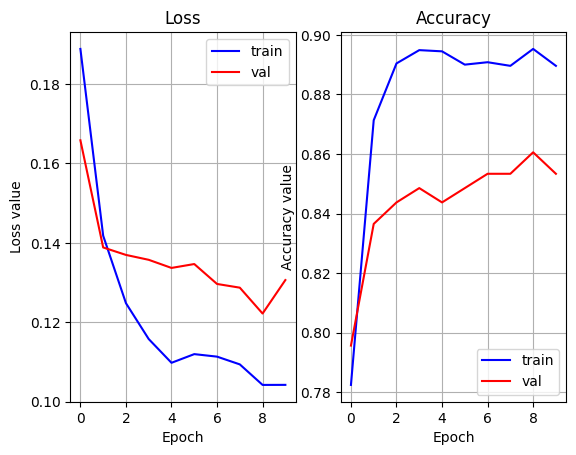

In [ ]:
from deep_learning_utils import train_eval_model


# hyperparameters for training our model
num_epochs = 10         # number of epochs (i.e., passes over the full dataset)
batch_size = 16         # batch size: number of data points to group together at a time
learning_rate = 0.01    # learning rate: tells by how much parameters are modified w.r.t. gradients
weight_decay = 0.001    # l1 regularisation on the model parameters (to prevent overfitting)
momentum = 0.9          # integrate gradients from previous steps for more robust descent
device = 'cpu'          # GPU acceleration is not really needed for such a small model.
                        # However, if you want to use it, switch the Colab
                        # runtime to GPU, provide "cuda" as device, and re-run the code blocks above.


# train and validate our model
model, loss_train, loss_val, acc_train, acc_val = train_eval_model(data_train,
                                                                   data_val,
                                                                   covariate_ids,
                                                                   species_names,
                                                                   model,       # our model instance
                                                                   num_epochs,
                                                                   batch_size,
                                                                   learning_rate,
                                                                   weight_decay,
                                                                   momentum,
                                                                   device)


# visualise loss and accuracy curves over epochs
plt.figure()
plt.subplot(1,2,1)
plt.plot(np.arange(num_epochs), loss_train, 'b-', label='train')
plt.plot(np.arange(num_epochs), loss_val, 'r-', label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(np.arange(num_epochs), acc_train, 'b-', label='train')
plt.plot(np.arange(num_epochs), acc_val, 'r-', label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

#### ❓
* Is the model performing well according to the plotted figures you can see? If not, can you think
  of what problem may be prevalent, and how to possibly prevent it?

_➡️ Loss values are decreasing and accuracy is rising, but the discrepancy between training and validation set hint towards overfitting (then again, the validation set isn't the best as we have seen in the random forest case above)._

* Modify the hyperparameters a bit: increase the learning rate to 0.1. What happens, and why?

_➡️ Higher learning rate = more aggressive parameter tuning. A high learning rate might lead to the model making big jumps in the first one or two epochs, but then plateau quickly. Oftentimes, it is better to use a smaller learning rate and let the model train for longer._

* Likewise, increase the number of epochs to e.g. 50 (GPU recommended). How much does this help?

_➡️ Loss values may go down further, but at some point the accuracy saturates._


Once you have a set of hyperparameters you like, you can use that model to predict the test set and
map below, as you did for random forests above.

Note that we _could_ conduct a hyperparameter grid search with default values like we did above. In
practice, this is less done for deep learning models because they are so costly to train.

## 5.4 Prediction and validation

Now that we have trained our model, we can use it to predict our test set, exactly like the random
forest above. The basic function for this is also provided and used in the code below.

100%|██████████| 77/77 [00:00<00:00, 2258.69it/s]


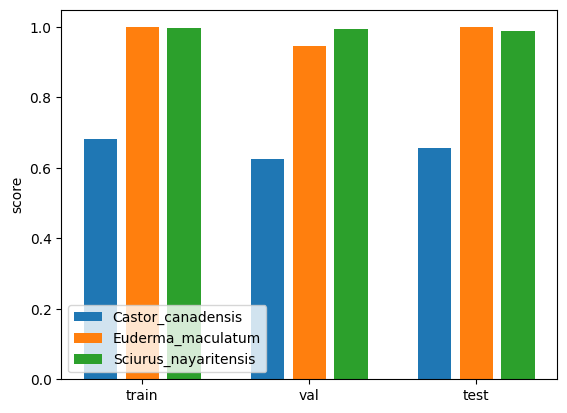

In [ ]:
from deep_learning_utils import predict_model


# predict all three sets with final model
datasets = {'train': data_train, 'val': data_val, 'test': data_test}
scores = {}
for split, dataset in datasets.items():
    # predict
    predictions = predict_model(dataset,
                                covariate_ids,
                                species_names,
                                model,
                                batch_size,
                                device)

    # evaluate
    scores[split] = evaluate(predictions, dataset)

# combine
scores = pd.DataFrame(scores)

# plot
plt.figure()
for sidx, species in enumerate(species_names):
    plt.bar(range(sidx, len(species_names)*4, 4), scores.loc[species], label=species)
plt.ylabel('score')
plt.xticks(range(1, len(species_names)*4, 4), ('train', 'val', 'test'))
plt.legend(loc='lower left')
plt.show()

#### ❓
* Compare these results to the accuracy obtained with random forests (Section 4.1 above). Are you
  satisfied with these results, resp., did you expect them to be like that?

_➡️ Results may differ across experimental runs; oftentimes, random forests are better. This may be expected due to (i.) dataset size (we don't have a lot of training points) and (ii.) suboptimal hyperparameters and/or deep learning model architectural design. Also NOTE: our deep learning model is a multi-SDM and therefore may seem better on paper than it actually is, due to the biases we explored above in the splitting procedure._

## 5.5 Predict map

Let us predict and plot points on a map grid like we did for random forests in Section 4.2 above.

In [ ]:
# 1. Make sure to re-run section 4.2 above if you have restarted your runtime with GPU support.

# predict map using deep learning model
pred_map_dl = predict_model(data_map,
                            covariate_ids,
                            species_names,
                            model,
                            batch_size,
                            device)

100%|██████████| 793/793 [00:00<00:00, 2326.15it/s]


In [ ]:
# plot
df_map_dl = pd.concat((pred_map_dl, data_map), axis=1)

def plot_predictions(species: str,
                     plot_observations: bool=False) -> None:
    traces = []
    fig_pred = px.scatter_mapbox(df_map_dl,
                                 lat='lat',
                                 lon='lon',
                                 title='Predictions',
                                 hover_name=species,
                                 color=species,
                                 height=600,
                                 width=800,
                                 zoom=2)
    traces.append(fig_pred.data[0])
    if plot_observations:
        fig2 = px.scatter_mapbox(data.loc[(data['species']==species) * \
                                          (data['is_presence']==True)],
                                 lat='lat',
                                 lon='lon',
                                 title='Observations',
                                 hover_name='species',
                                 color_discrete_sequence=['green'],
                                 height=600,
                                 width=800,
                                 zoom=2)
        traces.append(fig2.data[0])
    fig = go.FigureWidget(data=traces)
    fig.update_layout(mapbox_style='open-street-map')
    fig.show()


species_wdgt = widgets.Dropdown(options=species_names, description='species:')
show_obs_wdgt = widgets.Checkbox(description='show observations')

def redraw_figure(*args, **kwargs):
    clear_output(wait=True)
    display(species_wdgt, show_obs_wdgt, fig)
    plot_predictions(species=species_wdgt.value,
                     plot_observations=show_obs_wdgt.value)

species_wdgt.observe(redraw_figure, names=['value'])
show_obs_wdgt.observe(redraw_figure, names=['value'])


redraw_figure()

Dropdown(description='species:', options=('Castor_canadensis', 'Euderma_maculatum', 'Sciurus_nayaritensis'), v…

Checkbox(value=False, description='show observations')

FigureWidget({
    'data': [{'hovertemplate': ('<b>%{hovertext}</b><br><br>lat' ... '%{marker.color}<extra></extra>'),
              'hovertext': array([0.87602365, 0.83594894, 0.78930217, ..., 0.92891884, 0.92891788,
                                  0.88670361]),
              'lat': array([-1.7870363, -1.7870363, -1.7870363, ..., 77.7129637, 77.7129637,
                            77.7129637]),
              'legendgroup': '',
              'lon': array([-80.4734456, -79.9734456, -79.4734456, ..., -69.9734456, -68.9734456,
                            -68.4734456]),
              'marker': {'color': array([0.87602365, 0.83594894, 0.7893022 , ..., 0.92891884, 0.9289179 ,
                                         0.8867036 ], dtype=float32),
                         'coloraxis': 'coloraxis'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'subplot': 'mapbox',
              'type': 'scattermapbox',
              'uid': '22b0e36

#### ❓
* What patterns can you observe that the deep learning model makes? _Tip:_ compare across species.

_➡️ The deep learning model seems either completely over- or underconfident in its predictions, even if it is wrong. The model seems to focus mostly on the most abundant species (Castor canadensis)._

* Are these predictions what you expected based on _e.g._ the accuracy scores above? Why, resp. why
  not?

_➡️ This behaviour is expected due to (i.) the cross-entropy loss used, and (ii.) the imbalance between species. The predictions, however, do not seem to match the accuracy metrics (maps generally look much worse than what $AUC_{ROC}$ scores would suggest). This indicates that (i.) $AUC_{ROC}$ does not tell the whole story, and (ii.) our dataset is not optimal (e.g., in type and number of pseudo-absences)._

_➡️ Perhaps also interesting: using `observations_b.csv` (uniform random) reduces performance gap between training and validation set (as expected); maps don't look much better, though (the "jagginess" likely comes from including many pseudo-absences with extreme values)._